#   Video Segmentation with MedSAM2
This notebook shows how to use MedSAM2 for video segmentation inference. 

If running locally using jupyter, first install `MedSAM2` in your environment using the [installation instructions](https://github.com/bowang-lab/MedSAM2?tab=readme-ov-file#installation) in the repository.

### For Downloading the demo data

In [ ]:
!pip install gdown

## Download demo dataset

Dataset should be organized into the following structure
```
data/
├── images/
│   ├── video_1/
│   │   ├── frame001.jpg
│   │   ├── frame002.jpg
│   │   └── ...
│   ├── video_2
│   └── ...
└── masks/
    ├── video_1/
    │   ├── frame001.png
    │   ├── frame002.png
    │   └── ...
    ├── video_2
    └── ...
```

The Google Drive download link may be temporarily restricted due to high download volume

You can also access the demo case here:
[images](https://drive.google.com/file/d/195PK-HI2wP4rM6PZeocmvn_eLNHWPwNY/view?usp=drive_link),
[masks](https://drive.google.com/file/d/1pH4YccwNrcngUxKeYXz_fsUBHi2ldaDm/view?usp=drive_link), and upload to colab manually :)

In [ ]:
# Download demo dataset
!mkdir -p data-vid
folder_id = "19_fsP6zRm2nWGiPy2hEktE4rJ9SvrWsb"
!gdown --folder https://drive.google.com/drive/folders/{folder_id} -O data-vid

# unzip data
!mkdir -p data-vid/images
!mkdir -p data-vid/masks
!unzip data-vid/patient0213_4CH.zip -d data-vid/images
!unzip data-vid/patient0213_4CH-masks.zip -d data-vid/masks

## Load Packages and MedsSAM2 video predictor

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2_video_predictor

# helper functions
DAVIS_PALETTE = b"\x00\x00\x00\x80\x00\x00\x00\x80\x00\x80\x80\x00\x00\x00\x80\x80\x00\x80\x00\x80\x80\x80\x80\x80@\x00\x00\xc0\x00\x00@\x80\x00\xc0\x80\x00@\x00\x80\xc0\x00\x80@\x80\x80\xc0\x80\x80\x00@\x00\x80@\x00\x00\xc0\x00\x80\xc0\x00\x00@\x80\x80@\x80\x00\xc0\x80\x80\xc0\x80@@\x00\xc0@\x00@\xc0\x00\xc0\xc0\x00@@\x80\xc0@\x80@\xc0\x80\xc0\xc0\x80\x00\x00@\x80\x00@\x00\x80@\x80\x80@\x00\x00\xc0\x80\x00\xc0\x00\x80\xc0\x80\x80\xc0@\x00@\xc0\x00@@\x80@\xc0\x80@@\x00\xc0\xc0\x00\xc0@\x80\xc0\xc0\x80\xc0\x00@@\x80@@\x00\xc0@\x80\xc0@\x00@\xc0\x80@\xc0\x00\xc0\xc0\x80\xc0\xc0@@@\xc0@@@\xc0@\xc0\xc0@@@\xc0\xc0@\xc0@\xc0\xc0\xc0\xc0\xc0 \x00\x00\xa0\x00\x00 \x80\x00\xa0\x80\x00 \x00\x80\xa0\x00\x80 \x80\x80\xa0\x80\x80`\x00\x00\xe0\x00\x00`\x80\x00\xe0\x80\x00`\x00\x80\xe0\x00\x80`\x80\x80\xe0\x80\x80 @\x00\xa0@\x00 \xc0\x00\xa0\xc0\x00 @\x80\xa0@\x80 \xc0\x80\xa0\xc0\x80`@\x00\xe0@\x00`\xc0\x00\xe0\xc0\x00`@\x80\xe0@\x80`\xc0\x80\xe0\xc0\x80 \x00@\xa0\x00@ \x80@\xa0\x80@ \x00\xc0\xa0\x00\xc0 \x80\xc0\xa0\x80\xc0`\x00@\xe0\x00@`\x80@\xe0\x80@`\x00\xc0\xe0\x00\xc0`\x80\xc0\xe0\x80\xc0 @@\xa0@@ \xc0@\xa0\xc0@ @\xc0\xa0@\xc0 \xc0\xc0\xa0\xc0\xc0`@@\xe0@@`\xc0@\xe0\xc0@`@\xc0\xe0@\xc0`\xc0\xc0\xe0\xc0\xc0\x00 \x00\x80 \x00\x00\xa0\x00\x80\xa0\x00\x00 \x80\x80 \x80\x00\xa0\x80\x80\xa0\x80@ \x00\xc0 \x00@\xa0\x00\xc0\xa0\x00@ \x80\xc0 \x80@\xa0\x80\xc0\xa0\x80\x00`\x00\x80`\x00\x00\xe0\x00\x80\xe0\x00\x00`\x80\x80`\x80\x00\xe0\x80\x80\xe0\x80@`\x00\xc0`\x00@\xe0\x00\xc0\xe0\x00@`\x80\xc0`\x80@\xe0\x80\xc0\xe0\x80\x00 @\x80 @\x00\xa0@\x80\xa0@\x00 \xc0\x80 \xc0\x00\xa0\xc0\x80\xa0\xc0@ @\xc0 @@\xa0@\xc0\xa0@@ \xc0\xc0 \xc0@\xa0\xc0\xc0\xa0\xc0\x00`@\x80`@\x00\xe0@\x80\xe0@\x00`\xc0\x80`\xc0\x00\xe0\xc0\x80\xe0\xc0@`@\xc0`@@\xe0@\xc0\xe0@@`\xc0\xc0`\xc0@\xe0\xc0\xc0\xe0\xc0  \x00\xa0 \x00 \xa0\x00\xa0\xa0\x00  \x80\xa0 \x80 \xa0\x80\xa0\xa0\x80` \x00\xe0 \x00`\xa0\x00\xe0\xa0\x00` \x80\xe0 \x80`\xa0\x80\xe0\xa0\x80 `\x00\xa0`\x00 \xe0\x00\xa0\xe0\x00 `\x80\xa0`\x80 \xe0\x80\xa0\xe0\x80``\x00\xe0`\x00`\xe0\x00\xe0\xe0\x00``\x80\xe0`\x80`\xe0\x80\xe0\xe0\x80  @\xa0 @ \xa0@\xa0\xa0@  \xc0\xa0 \xc0 \xa0\xc0\xa0\xa0\xc0` @\xe0 @`\xa0@\xe0\xa0@` \xc0\xe0 \xc0`\xa0\xc0\xe0\xa0\xc0 `@\xa0`@ \xe0@\xa0\xe0@ `\xc0\xa0`\xc0 \xe0\xc0\xa0\xe0\xc0``@\xe0`@`\xe0@\xe0\xe0@``\xc0\xe0`\xc0`\xe0\xc0\xe0\xe0\xc0"

def load_ann_png(path):
    """Load a PNG file as a mask and its palette."""
    mask = Image.open(path)
    palette = mask.getpalette()
    mask = np.array(mask).astype(np.uint8)
    return mask, palette

def get_per_obj_mask(mask):
    """Split a mask into per-object masks."""
    object_ids = np.unique(mask)
    object_ids = object_ids[object_ids > 0].tolist()
    per_obj_mask = {object_id: (mask == object_id) for object_id in object_ids}
    return per_obj_mask

def put_per_obj_mask(per_obj_mask, height, width):
    """Combine per-object masks into a single mask."""
    mask = np.zeros((height, width), dtype=np.uint8)
    object_ids = sorted(per_obj_mask)[::-1]
    for object_id in object_ids:
        object_mask = per_obj_mask[object_id]
        object_mask = object_mask.reshape(height, width)
        mask[object_mask] = object_id
    return mask

def load_masks_from_dir(input_mask_path):
    input_mask, input_palette = load_ann_png(input_mask_path)
    per_obj_input_mask = get_per_obj_mask(input_mask)

    return per_obj_input_mask, input_palette

def save_predictions_to_dir(
    output_mask_dir,
    video_name,
    frame_name,
    per_obj_output_mask,
    height,
    width,
):
    """Save masks to a directory as PNG files."""
    os.makedirs(os.path.join(output_mask_dir, video_name), exist_ok=True)

    output_mask = put_per_obj_mask(per_obj_output_mask, height, width)
    output_mask_path = os.path.join(
        output_mask_dir, video_name, f"{frame_name}.png"
    )
    assert output_mask.dtype == np.uint8
    assert output_mask.ndim == 2
    output_mask = Image.fromarray(output_mask)
    output_mask.save(output_mask_path)

def create_overlay(img_path, mask_path, palette):
    """Create an overlay of an image and a mask."""
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    mask.putpalette(palette)
    mask_rgb = mask.convert("RGB")
    mask_rgb = mask_rgb.resize(img.size, Image.NEAREST)
    overlay = Image.blend(img, mask_rgb, alpha=0.5)
    return overlay
    

In [6]:
# change to customized path
VIDEO_DIR = "data-vid/images"
VIDEO_NAME = "patient0213_4CH"
INITIAL_MASK_PROMPT = "data-vid/masks/patient0213_4CH/patient0213_4CH_half_sequence-000.png"
OUTPUT_DIR = "data-vid/output"

MODEL_CONFIG = "/configs/sam2.1_hiera_t512.yaml"
MODEL_CHECKPOINT = "checkpoints/MedSAM2_latest.pt"
# Download demo dataset
predictor = build_sam2_video_predictor(
    config_file=MODEL_CONFIG,
    ckpt_path=MODEL_CHECKPOINT,
    apply_postprocessing=True,
    # hydra_overrides_extra=hydra_overrides_extra,
    vos_optimized=  True,
)

## Prepare Inference and Add Initial Mask Prompt

In [7]:
# load the video frames
frame_names = [
        os.path.splitext(p)[0]
        for p in os.listdir(os.path.join(VIDEO_DIR, VIDEO_NAME))
        if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
    ]
frame_names = list(sorted(frame_names))
inference_state = predictor.init_state(
    video_path=os.path.join(VIDEO_DIR, VIDEO_NAME), async_loading_frames=False
)
height = inference_state["video_height"]
width = inference_state["video_width"]
input_palette = None

# Add input masks to MedSAM2 inference state before propagation
object_ids_set = None
input_frame_idx = 0  # use first frame as mask input
try:
    per_obj_input_mask, input_palette = load_masks_from_dir(input_mask_path=INITIAL_MASK_PROMPT)
except FileNotFoundError as e:
    raise RuntimeError(
        f"In {VIDEO_NAME=}, failed to load input mask for frame {input_frame_idx=}. "
        "Please add the `--track_object_appearing_later_in_video` flag "
        "for VOS datasets that don't have all objects to track appearing "
        "in the first frame (such as LVOS or YouTube-VOS)."
    ) from e

# get the list of object ids to track from the first input frame
if object_ids_set is None:
    object_ids_set = set(per_obj_input_mask)
for object_id, object_mask in per_obj_input_mask.items():
    # check and make sure no new object ids appear only in later frames
    if object_id not in object_ids_set:
        raise RuntimeError(
            f"In {VIDEO_NAME=}, got a new {object_id=} appearing only in a "
            f"later {input_frame_idx=} (but not appearing in the first frame). "
            "Please add the `--track_object_appearing_later_in_video` flag "
            "for VOS datasets that don't have all objects to track appearing "
            "in the first frame (such as LVOS or YouTube-VOS)."
        )
    predictor.add_new_mask(
        inference_state=inference_state,
        frame_idx=input_frame_idx,
        obj_id=object_id,
        mask=object_mask,
            )
    
# check and make sure we have at least one object to track
if object_ids_set is None or len(object_ids_set) == 0:
    raise RuntimeError(
        f"In {VIDEO_NAME=}, got no object ids on {input_frame_idx=}. "
        "Please add the `--track_object_appearing_later_in_video` flag "
        "for VOS datasets that don't have all objects to track appearing "
        "in the first frame (such as LVOS or YouTube-VOS)."
    )

frame loading (JPEG): 100%|█████████████████████| 21/21 [00:00<00:00, 22.31it/s]
/home/ankan_opencv/officework/vs-code/MedSAM2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at /pytorch/aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:776.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/ankan_opencv/officework/vs-code/MedSAM2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at /pytorch/aten/src/ATen/native/transformers/sdp_utils_cpp.h:551.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/ankan_opencv/officework/vs-code/MedSAM2/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at /pytorch/aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:778.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/an

## Run Inference

In [8]:
# run propagation throughout the video
os.makedirs(os.path.join(OUTPUT_DIR, VIDEO_NAME), exist_ok=True)

video_segments = {}  # Store the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(
    inference_state
):
    per_obj_output_mask = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }
    video_segments[out_frame_idx] = per_obj_output_mask

# write the output masks
for out_frame_idx, per_obj_output_mask in video_segments.items():
    # save raw prediction results
    save_predictions_to_dir(
        output_mask_dir=OUTPUT_DIR,
        video_name=VIDEO_NAME,
        frame_name=frame_names[out_frame_idx],
        per_obj_output_mask=per_obj_output_mask,
        height=height,
        width=width,
    )

propagate in video: 100%|███████████████████████| 21/21 [00:01<00:00, 16.18it/s]


## Visualize Inference Results
Visualize segmentation results for 3 key frames at the 25%, 50%, and 75% position in the sequence

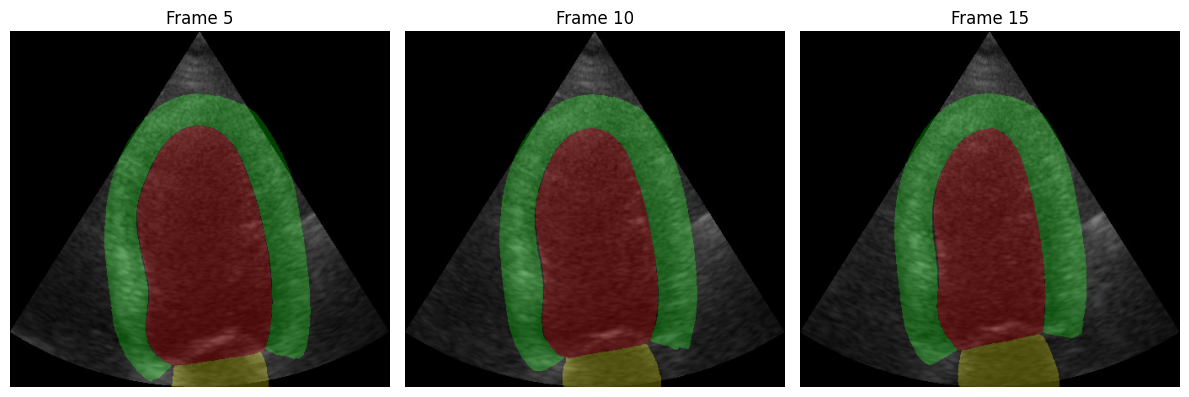

In [9]:
output_palette = input_palette or DAVIS_PALETTE
images = sorted(os.listdir(os.path.join(VIDEO_DIR, VIDEO_NAME)))
masks = sorted(os.listdir(os.path.join(OUTPUT_DIR, VIDEO_NAME)))
num_frames = len(images)
selected_indices = [int(num_frames * 0.25), int(num_frames * 0.5), int(num_frames * 0.75)]
selected_frames = [(images[i], masks[i]) for i in selected_indices]

plt.figure(figsize=(12, 4))
for idx, (img, mask) in enumerate(selected_frames):
    overlay = create_overlay(os.path.join(VIDEO_DIR, VIDEO_NAME, img), os.path.join(OUTPUT_DIR, VIDEO_NAME, mask), output_palette)

    plt.subplot(1, 3, idx + 1)
    plt.imshow(overlay)
    plt.title(f"Frame {int(num_frames*0.25*(idx+1))}")
    plt.axis("off")

plt.tight_layout()
plt.show()